In [189]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gowrishankarp/newspaper-text-summarization-cnn-dailymail")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail/versions/2


## Data Extraction

In [ ]:
# List the files in the downloaded dataset directory
!ls  /root/.cache/kagglehub/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail/versions/2/cnn_dailymail

test.csv  train.csv  validation.csv


In [207]:
import polars as pl

# train df
df = pl.read_csv("/root/.cache/kagglehub/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail/versions/2/cnn_dailymail/train.csv")
val_df = pl.read_csv("/root/.cache/kagglehub/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail/versions/2/cnn_dailymail/validation.csv")
test_df = pl.read_csv("/root/.cache/kagglehub/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail/versions/2/cnn_dailymail/test.csv")


print("Train shape:", df.shape)
print("Val shape:  ", val_df.shape)
print("Test shape: ", test_df.shape)

Train shape: (287113, 3)
Val shape:   (13368, 3)
Test shape:  (11490, 3)


In [208]:
df = df.sample(fraction=0.001, seed=42)
val_df = val_df.sample(fraction=0.001, seed=42)
test_df = test_df.sample(fraction=0.001, seed=42)

print("Train shape:", df.shape)
print("Val shape:  ", val_df.shape)
print("Test shape: ", test_df.shape)

Train shape: (287, 3)
Val shape:   (13, 3)
Test shape:  (11, 3)


In [ ]:
print(df.columns)

['article', 'highlights', 'highlights_words']


In [209]:
def clean_text(df: pl.DataFrame) -> pl.DataFrame:
  return (
      df
      .select(["article", "highlights"])
      .drop_nulls(subset=["article", "highlights"])
      .with_columns([
          pl.col("article").str.strip_chars(),
          pl.col("highlights").str.strip_chars(),
      ])
  )

df = clean_text(df)
test_df  = clean_text(test_df)
val_df = clean_text(val_df)

print("Train shape:", df.shape)
print("Val shape:  ", val_df.shape)
print("Test shape: ", test_df.shape)

Train shape: (287, 2)
Val shape:   (13, 2)
Test shape:  (11, 2)


In [ ]:
df.sample()

article,highlights
str,str
"""By . Rob Cooper . PUBLISHED: .…","""Petty criminal Steven Cane, 25…"


## EDA

In [193]:
def word_counts(df: pl.DataFrame) -> pl.DataFrame:
  return df.with_columns([
      pl.col("article").str.split(" ").list.len().alias("article_words"),
      pl.col("highlights").str.split(" ").list.len().alias("highlights_words")
  ])

df = word_counts(df)
df.sample(5)


article,highlights,article_words,highlights_words
str,str,u32,u32
"""Nicholas Stewart from Dowson T…","""Decision in the Federal Circui…",517,65
"""(CNN) -- It's the most romanti…","""Grand slam in tennis consists …",1521,51
"""By . Beth Stebner . PUBLISHED:…","""Sybrina Fulton said that she's…",1009,53
"""(CNN) -- The torch for the 20…","""Olympic flame due to arrive in…",489,46
"""A man has been arrested as par…","""Lester Ralph Jones, 63 has bee…",598,63


In [194]:
# Averages
avg_article_words = df["article_words"].mean()
avg_summary_words = df["highlights_words"].mean()

# Minimums
min_article_words = df["article_words"].min()
min_summary_words = df["highlights_words"].min()

# Maximums
max_article_words = df["article_words"].max()
max_summary_words = df["highlights_words"].max()

In [ ]:
print(f"Average words in article: {avg_article_words:.1f}")
print(f"Average words in summary: {avg_summary_words:.1f}")
print(f"Compression ratio: {avg_article_words / avg_summary_words:.1f}x")

print(f"\nMinimum words in article: {min_article_words}")
print(f"Minimum words in summary: {min_summary_words}")

print(f"\nMaximum words in article: {max_article_words}")
print(f"Maximum words in summary: {max_summary_words}")

Average words in article: 691.6
Average words in summary: 48.9
Compression ratio: 14.1x

Minimum words in article: 43
Minimum words in summary: 8

Maximum words in article: 2033
Maximum words in summary: 294


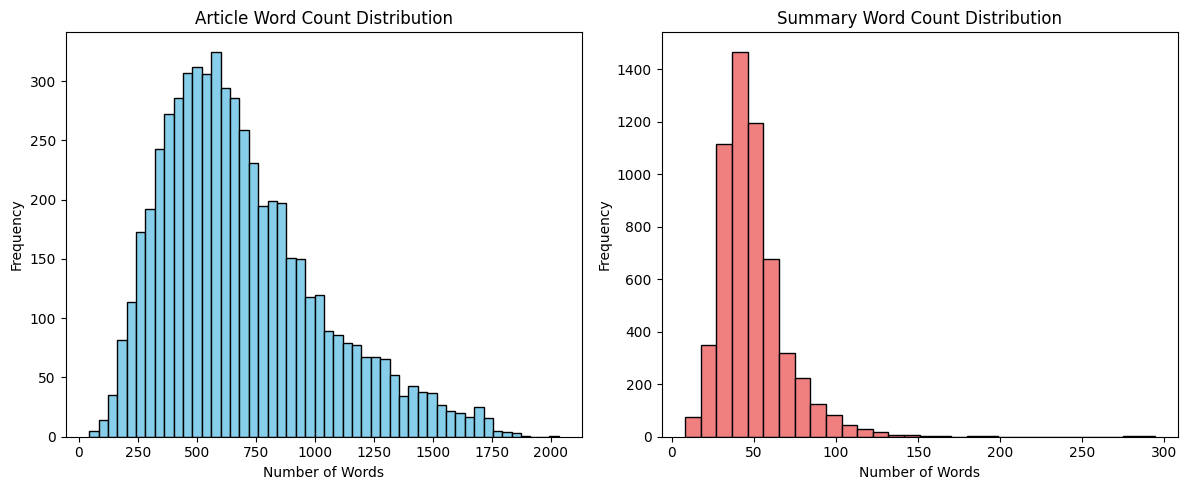

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Article word counts
plt.subplot(1, 2, 1)
plt.hist(df["article_words"], bins=50, color="skyblue", edgecolor="black")
plt.title("Article Word Count Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")

# Summary word counts
plt.subplot(1, 2, 2)
plt.hist(df["highlights_words"], bins=30, color="lightcoral", edgecolor="black")
plt.title("Summary Word Count Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [210]:
# Remove word count columns
df = df.drop([col for col in ["article_words", "summary_words"] if col in df.columns])

print("Final columns:", df.columns)

Final columns: ['article', 'highlights']


In [ ]:
print("abc")

## Tokenization

In [211]:
from datasets import Dataset

# Convert Polars to pandas
train_hf = Dataset.from_pandas(df.to_pandas())
val_hf = Dataset.from_pandas(val_df.to_pandas())

In [212]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Use consistent, fresh tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

# Verify pad token
print("Pad token ID:", tokenizer.pad_token_id)  # Should be 0 for T5

Pad token ID: 0


In [213]:
def preprocess_function(examples):
    inputs = ["summarize: " + doc for doc in examples["article"]]

    model_inputs = tokenizer(
        inputs,
        max_length=1024,
        truncation=True,
        padding=False
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["highlights"],
            max_length=150,
            truncation=True,
            padding=False
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [214]:
tokenized_train = train_hf.map(
    preprocess_function,
    batched=True,
    remove_columns=["article", "highlights"]
)

tokenized_val = val_hf.map(
    preprocess_function,
    batched=True,
    remove_columns=["article", "highlights"]
)

Map:   0%|          | 0/287 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/13 [00:00<?, ? examples/s]

In [215]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./t5-summarizer",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    predict_with_generate=True,
    generation_max_length=150,
    generation_num_beams=4,
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="rouge1",
    greater_is_better=True,
    report_to="none",
    fp16=True,
)

In [216]:
from transformers import DataCollatorForSeq2Seq, Seq2SeqTrainer

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    label_pad_token_id=-100,  # ← This is handled safely
    pad_to_multiple_of=8 if training_args.fp16 else None
)

In [ ]:
!pip install evaluate

In [217]:
import evaluate
import numpy


In [ ]:
!pip install rouge_score

In [218]:
rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    preds, labels = eval_pred

    # Replace -100 with pad token for decoding
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # Skip special tokens during decoding
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Clean up: remove empty strings if any
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]

    result = rouge.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True,
        rouge_types=["rouge1", "rouge2", "rougeL"]
    )
    return {k: round(v, 4) for k, v in result.items()}

In [219]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-3226501058.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [220]:
# Start training!
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
1,No log,1.530942,0.414700,0.213100,0.284800
2,2.004900,1.534233,0.424700,0.216000,0.291600
3,1.643600,1.544437,0.424100,0.210300,0.293500


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=216, training_loss=1.8091443379720051, metrics={'train_runtime': 111.1946, 'train_samples_per_second': 7.743, 'train_steps_per_second': 1.943, 'total_flos': 228862986289152.0, 'train_loss': 1.8091443379720051, 'epoch': 3.0})

In [221]:
trainer.save_model("./t5-summarizer-final")
tokenizer.save_pretrained("./t5-summarizer-final")

('./t5-summarizer-final/tokenizer_config.json',
 './t5-summarizer-final/special_tokens_map.json',
 './t5-summarizer-final/spiece.model',
 './t5-summarizer-final/added_tokens.json')

In [222]:
import random

test_sample = test_df.sample(n=1).to_dicts()[0]
article = test_sample["article"]
act_summary = test_sample["highlights"]

print("\t---- Original Article ----")
print(f"{article} \n")

print("\t---- Actual Summary----")
print(act_summary + "\n")

input_text = "summarize: " + article
# Tokenize
inputs = tokenizer(
    input_text,
    return_tensors="pt",
    max_length=1024,
    truncation=True,
    padding="max_length"
).input_ids.to(model.device)

# Generate
outputs = model.generate(
    inputs,
    max_length=150,
    num_beams=4,
    early_stopping=True,
    no_repeat_ngram_size=2
)

# Decode
generated_summary = tokenizer.decode(outputs[0], skip_special_tokens=True)

print("\t---- Generated Summary ----")
generated_summary

	---- Original Article ----
Some teenagers get driving lessons from their parents. Other teens are taught by licensed instructors. But Malia Obama isn't your average 16-year-old: Her driving lessons were provided by the U.S. Secret Service. Asked who taught Malia how to drive, first lady Michelle Obama told celebrity chef and daytime talk-show host Rachael Ray in an interview that it was the armed agents who provide around-the-clock security for the family. Scroll down for video . Famous family: Malia Obama, seen with her mother Michelle Obama in April 2009, reportedly was taught how to drive by Secret Service agents . 'The Secret Service, actually, because they wouldn't let me in the car with her,' Mrs. Obama said in an excerpt of the interview that was released by Ray's program. The full interview is set to air Thursday. Mrs. Obama hasn't driven herself in seven or eight years, she said. She added that driving gives Malia 'a sense of normalcy,' helping her feel like the rest of her f

"Michelle Obama told celebrity chef and daytime talk-show host Rachael Ray that it was the armed agents who provide around-the-clock security for Malia Obama. The full interview is set to air Thursday. Mrs. Obama hasn't driven herself in seven or eight years, she said."